# Drop interacting with a hemispherical defect

The notebook reads Surface Evolver simulation results (obtained by running drop_afm.fe or force_series.cmd),
converts data into real units and prepares plots to compare results.

## Import libraries

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.optimize import curve_fit

## Set physical parameters

In [3]:
volume_drop = 84e-15 #drop volume (m3)
spot_size = 17.5e-6 #spot size on cantilever (m)
surf_tens = 69.7e-3 #surface tension (N/m)
defect_radius = 220e-9 #radius of defect

#factor to redimensionalize simulation results
s = ((3*volume_drop)/(4*np.pi))**(1/3)

## Combine simulation result data files

In [ ]:
#list of file paths to combine
file_list = [f'data/hemisphere_v8_CAs108_CAd70/results_azimuthang{i}.txt' for i in [0,30,45,60]]
# file_list = ['data/hemisphere_v5/results_azimuthang0.txt', 'data/hemisphere_v5/results_azimuthang0_contactang114.txt',
            # 'data/hemisphere_v5/results_azimuthang0_contactangdef10.txt']

data_list = []
for file_i in file_list:
    data_i = pd.read_csv(file_i, delimiter='\t')
    ind_start = np.argmin(abs(data_i['defect_disp']-(-data_i['defect_size']/2)))
    ind_end = np.argmin(data_i['force_laty_sum'])
    data_i['defect_disp_shifted'] = data_i['defect_disp'] - data_i['defect_disp'].iloc[ind_start]
    data_i['energy_shifted'] = data_i['total_energy'] - data_i['total_energy'].iloc[ind_start]

    data_i['defect_disp_end'] = data_i['defect_disp_shifted'].iloc[ind_end]
    data_i['force_latx_clean'] = data_i['force_latx_sum']
    data_i['force_laty_clean'] = data_i['force_laty_sum']
    data_i['force_norm_clean'] = data_i['force_norm_sum']
    data_i['energy_shifted_clean'] = data_i['energy_shifted']
    data_list.append(data_i)

data_all = pd.concat(data_list)

#convert to real units
data_all['Distance (um)'] = data_all['defect_disp_shifted']*s/1e-6 #um
data_all['Lateral force Y (nN)'] = data_all['force_latx_clean']*surf_tens*s/1e-9 #nN
data_all['Lateral force X (nN)'] = -data_all['force_laty_clean']*surf_tens*s/1e-9 #nN
data_all['Normal force (nN)'] = data_all['force_norm_clean']*surf_tens*s/1e-9 #nN
data_all['Energy (fJ)'] = (data_all['energy_shifted_clean'])*surf_tens*s*s/1e-15 #fJ
data_all['Energy full (fJ)'] = (data_all['energy_shifted'])*surf_tens*s*s/1e-15 #fJ

data_filt = data_all#.query("`defect_pos_angle` >  30").reset_index()
data_filt.rename(columns={"Distance (um)": "Distance X (µm)", #"Distance (µm)", 
                          "azimuthal_angle": "Azimuthal angle"}, inplace=True)
# data_filt['legend'] = 'CA_def=' + data_filt['defect_angle'].apply(str) + ', CA_sub=' + data_filt['bottom_angle'].apply(str)

#save data to excel
# data_filt.to_excel('data/hemisphere_v8_CAs108_CAd70/simulation_results.xlsx')

#rearrange data
# data_filt2 = data_filt[['Distance X (µm)', 'Azimuthal angle', 'Lateral force X (nN)', 'Lateral force Y (nN)', 'Energy (fJ)']]
# data_pivot = data_filt2.pivot(index=['Distance X (µm)'],
#                        columns='Azimuthal angle' ,values=['Lateral force X (nN)', 'Lateral force Y (nN)', 'Energy (fJ)'])
# data_pivot.to_excel('data/hemisphere_v8_CAs108_CAd70/simulation_results_pivot.xlsx')

## Plot force-distance and energy-distance curves

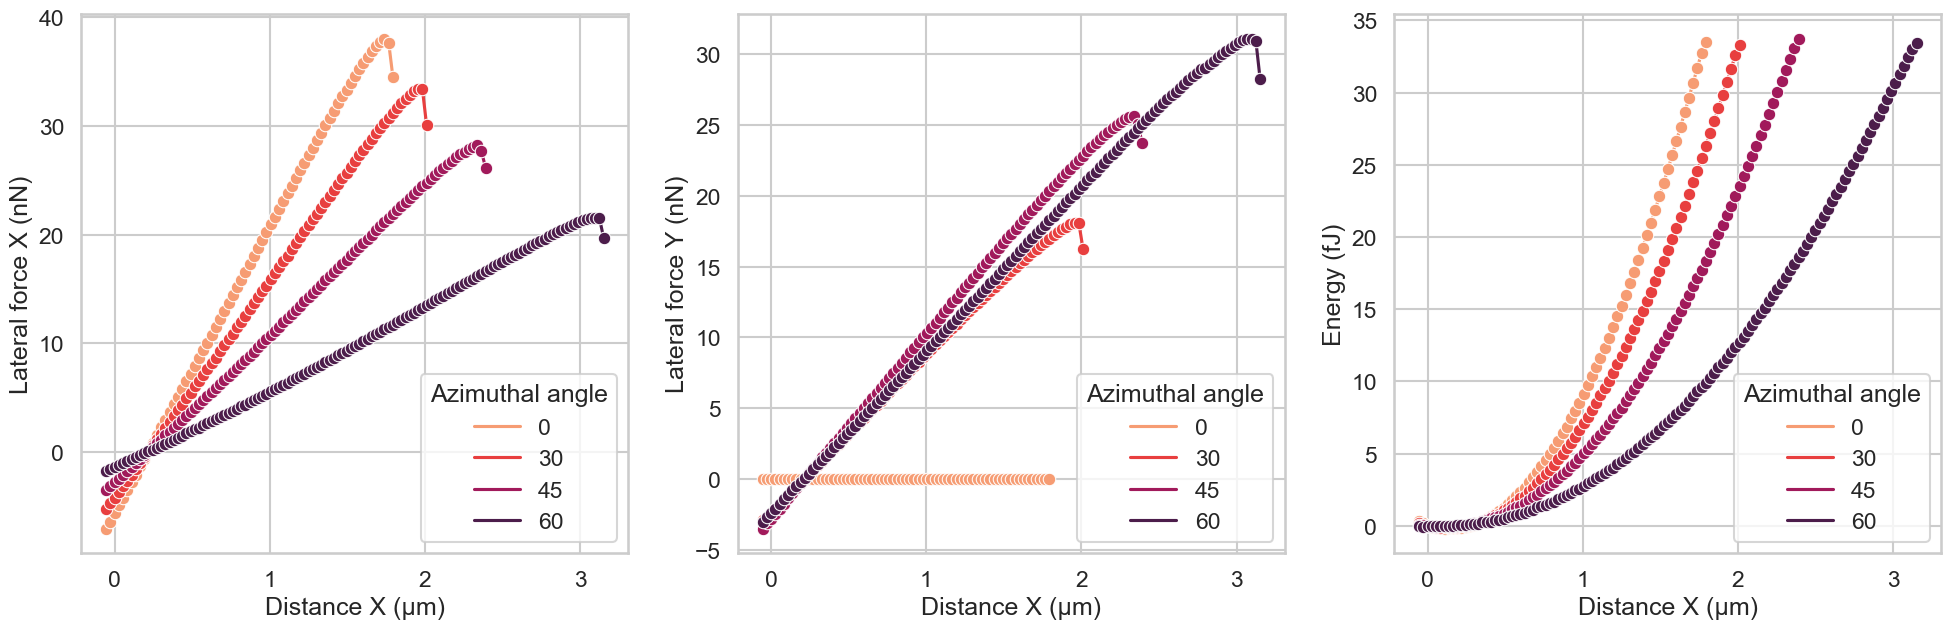

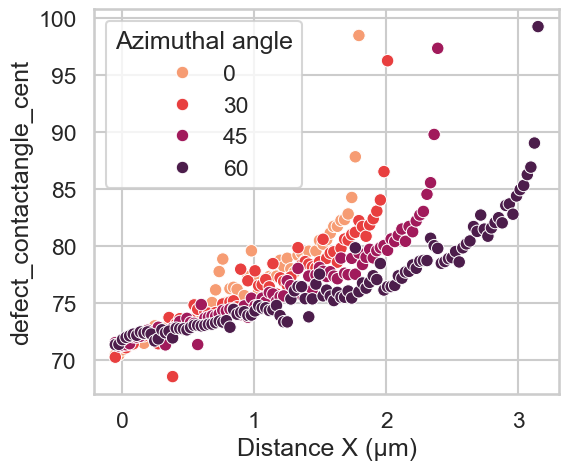

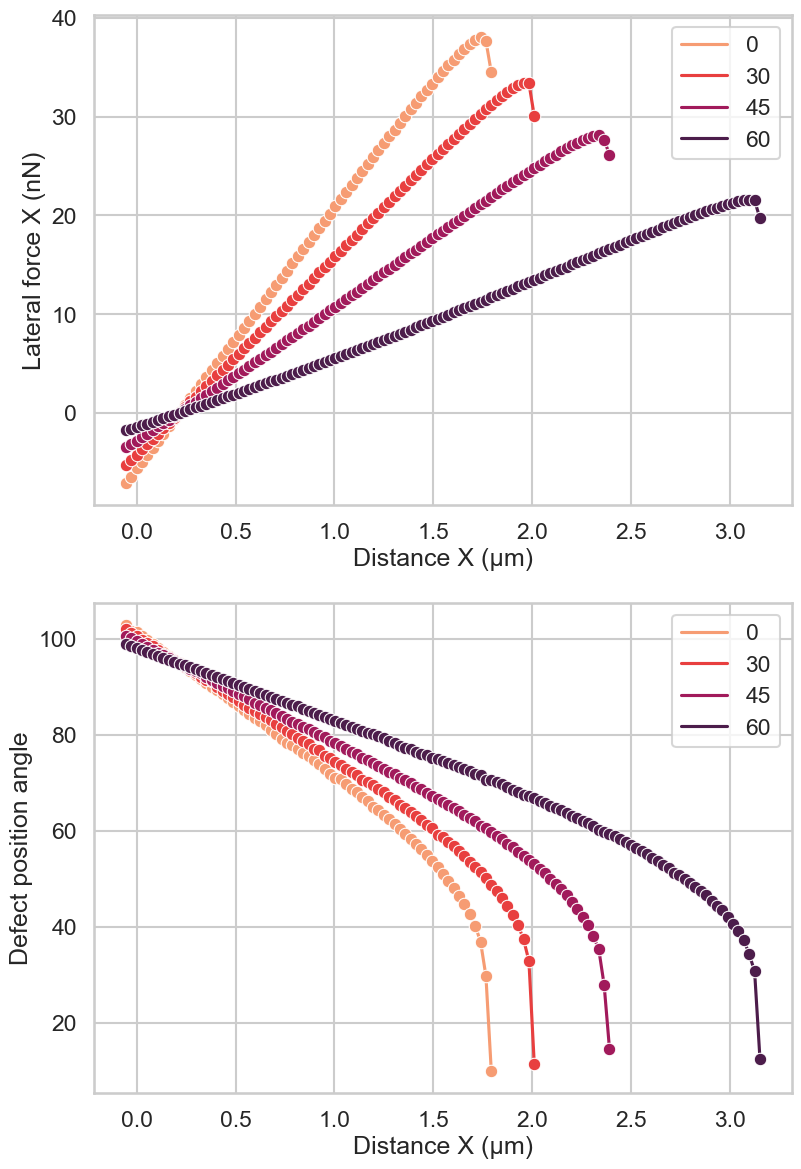

In [7]:
sns.set_context("talk")
sns.set_style("whitegrid")
color_palette = sns.color_palette("rocket_r", n_colors=4)

#set legend categories
cat_var = 'Azimuthal angle' #'Azimuthal angle', 'bottom_angle', 'legend'
data_filt[cat_var] = data_filt[cat_var].astype('category')

fig1, ax1 = plt.subplots(1,3, figsize=(24,7))
fig2, ax2 = plt.subplots(1,1, figsize=(6,5))
sns.lineplot(data=data_filt, x='Distance X (µm)', y='Lateral force X (nN)', hue=cat_var, ax=ax1[0], 
             palette=color_palette, linestyle="-")
sns.lineplot(data=data_filt, x='Distance X (µm)', y='Lateral force Y (nN)', hue=cat_var, ax=ax1[1], 
             palette=color_palette, linestyle="-")
sns.lineplot(data=data_filt, x='Distance X (µm)', y='Energy (fJ)', hue=cat_var, ax=ax1[2], 
             palette=color_palette, linestyle="-")

# Add markers to each line
for ax_i in ax1.flatten():
    sns.move_legend(ax_i, "lower right")
    for line in ax_i.lines:
        line.set_marker("o")  # Set the desired marker style

sns.scatterplot(data=data_filt, x='Distance X (µm)', y='defect_contactangle_cent', hue=cat_var, ax=ax2, palette=color_palette)
plt.show()



color_palette = sns.color_palette("rocket_r", n_colors=4)
fig3, ax3 = plt.subplots(2,1, figsize=(9,14))
sns.lineplot(data=data_filt, x='Distance X (µm)', y='Lateral force X (nN)', hue=cat_var, ax=ax3[0], 
             palette=color_palette, linestyle="-")
sns.lineplot(data=data_filt, x='Distance X (µm)', y='defect_pos_angle_cent', hue=cat_var, ax=ax3[1], 
             palette=color_palette, linestyle="-")


for ax_i in ax3.flatten():
    ax_i.legend() #removes legend title
    for line in ax_i.lines:
        line.set_marker("o")  # Set the desired marker style

# ax3[1].axhline(35, linestyle=':', color='black')
ax3[1].set_ylabel('Defect position angle')
plt.show()

#save  figures
# fig1.savefig('data/hemisphere_v8_CAs108_CAd70/simulation_plot_forces_v2.png', dpi=300)
# fig3.savefig('data/hemisphere_v6_CAs114_CAd70/simulation_plot_CAvaried.png', dpi=300)

## Plot peak lateral force and work vs azimuthal angle

Fitted A: 39.05809877362007, 44.02305632658496


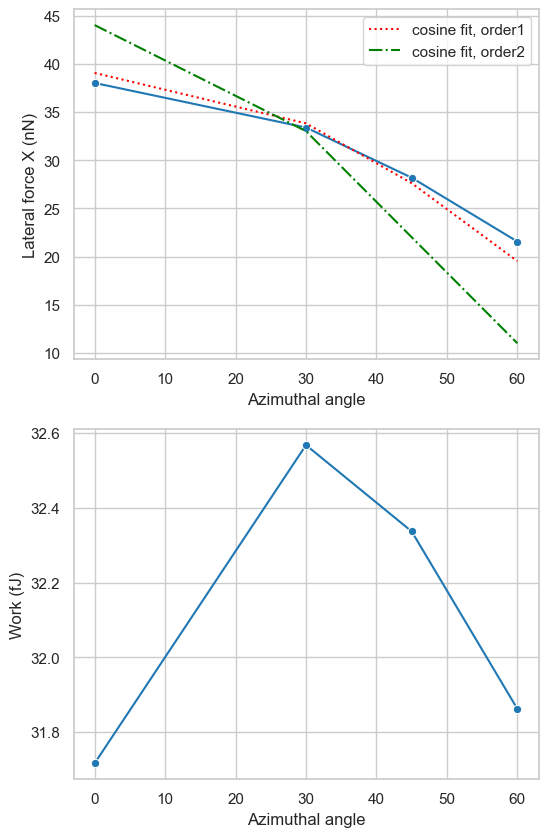

,Azimuthal angle,defect_angle,defect_disp,defect_posx,defect_posy,defect_size,beta,pin_radius,height,force_latx_sum,...,force_latx_clean,force_laty_clean,force_norm_clean,energy_shifted_clean,Distance X (µm),Lateral force Y (nN),Lateral force X (nN),Normal force (nN),Energy (fJ),Energy full (fJ)
66,0,70,0.056,0.000000,1.21788,0.016195,90,0.644131,1.10423,-2.534280e-09,...,-2.534280e-09,-0.020076,1.37868,0.000616,1.738776,-0.000005,38.016433,2610.717092,31.716766,31.716766
75,30,70,0.065,0.032500,1.21817,0.016195,90,0.644131,1.10423,9.533110e-03,...,9.533110e-03,-0.017633,1.37876,0.000633,1.983291,18.052233,33.391039,2610.868583,32.567803,32.567803
88,45,70,0.078,0.055154,1.21704,0.016195,90,0.644131,1.10423,1.353420e-02,...,1.353420e-02,-0.014885,1.37869,0.000629,2.336480,25.628839,28.186761,2610.736029,32.336919,32.336919
115,60,70,0.105,0.090933,1.21438,0.016195,90,0.644131,1.10423,1.642680e-02,...,1.642680e-02,-0.011386,1.37898,0.000619,3.070026,31.106368,21.560553,2611.285183,31.862257,31.862257


In [10]:
sns.set_context("notebook")

# Filter the data for multiple values
data_filt2 = data_filt[data_filt['defect_disp_shifted']==data_filt['defect_disp_end']]
# data_filt2 = data_filt[np.isclose(data_filt['defect_disp'], 0.08)]

fig3, ax3 = plt.subplots(2,1, figsize=(6,10))
sns.lineplot(data=data_filt2, x='Azimuthal angle', y='Lateral force X (nN)', ax=ax3[0], linestyle="-", legend=True)
sns.lineplot(data=data_filt2, x='Azimuthal angle', y='Energy (fJ)', ax=ax3[1], linestyle="-", legend=False)
# Add markers to each line
for ax_i in ax3:
    for line in ax_i.lines:
        line.set_marker("o")  # Set the desired marker style


# Define the fitting function
def model(x, A): #fit cosine function
    return A * np.cos(x*np.pi/180)**1

def model2(x, A): #fit cosine square function
    return A * np.cos(x*np.pi/180)**2

x_data = data_filt2['Azimuthal angle'].to_numpy()
y_data = data_filt2['Lateral force X (nN)'].to_numpy()
# Perform the curve fitting
popt, pcov = curve_fit(model, x_data, y_data, p0=[1.0])  # initial guess for A
popt2, pcov2 = curve_fit(model2, x_data, y_data, p0=[1.0])  # initial guess for A

# Extract fitted parameter
fitted_A = popt[0]
fitted_A2 = popt2[0]
print(f"Fitted A: {fitted_A}, {fitted_A2}")

# Plot the data and the fit
ax3[0].plot(x_data, model(x_data, fitted_A), label='cosine fit, order1', color='red', linestyle=':')
ax3[0].plot(x_data, model2(x_data, fitted_A2), label='cosine fit, order2', color='green', linestyle='-.')

ax3[1].set_ylabel('Work (fJ)')
ax3[0].legend()


plt.show()
display(data_filt2)

#save figure
# fig3.savefig('data/hemisphere_v8_CAs108_CAd70/simulation_plot_forcevsangle.png', dpi=300)